In [1]:
%matplotlib inline

In [2]:
from nbodykit.algorithms.fftpower import FFTPower
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh
import numpy as np
from nbodykit.lab import FFTPower
import matplotlib.pyplot as plt

In [3]:
fastpm_folder_name='data_collection/mlsimdata10/results-fastpm-random_seed-229761-folder-mlsimdata10'
za_folder_name='data_collection/mlsimdata10/results-za-random_seed-229761-folder-mlsimdata10'
twolpt_folder_name='data_collection/mlsimdata10/results-2lpt-random_seed-229761-folder-mlsimdata10'

In [4]:
seed='229761'
folder='mlsimdata10'

In [5]:
model_path='/lustre/project/tkcastrosim/CKWan/ml/model_checkpoints/doubledatanoaugment/best-checkpoint-epoch=495.ckpt'

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


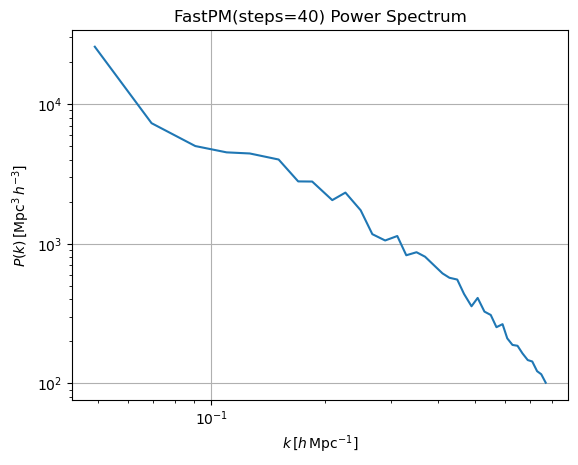

In [6]:
power_values_list = []
labels = [
    'fastpm-steps-40',
    '2lpt',
    'za',
    'unet'
]
fastpm_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
fastpm_mesh = fastpm_part.to_mesh(Nmesh=32,BoxSize=128)
fastpm_fft = FFTPower(fastpm_mesh, mode='1d', dk=0.02)

k_values = fastpm_fft.power['k']  # Array of k values
fastpm_power_values = fastpm_fft.power['power'].real 
power_values_list.append(fastpm_power_values)

plt.loglog(k_values, fastpm_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('FastPM(steps=40) Power Spectrum')
plt.grid(True)
plt.show()

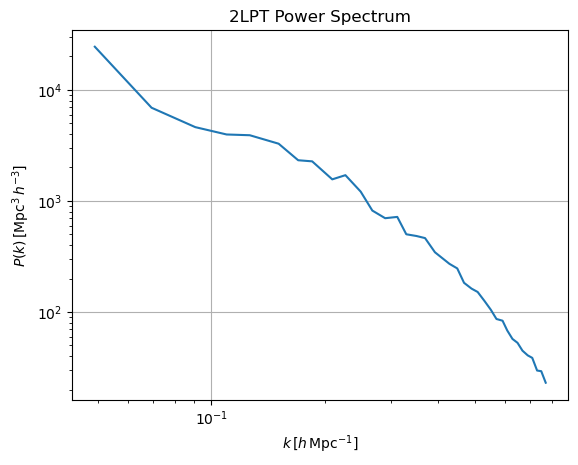

In [7]:
twolpt_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+twolpt_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
twolpt_mesh = twolpt_part.to_mesh(Nmesh=32,BoxSize=128)
twolpt_fft = FFTPower(twolpt_mesh, mode='1d', dk=0.02)

twolpt_power_values = twolpt_fft.power['power'].real 
power_values_list.append(twolpt_power_values)

plt.loglog(k_values, twolpt_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('2LPT Power Spectrum')
plt.grid(True)
plt.show()

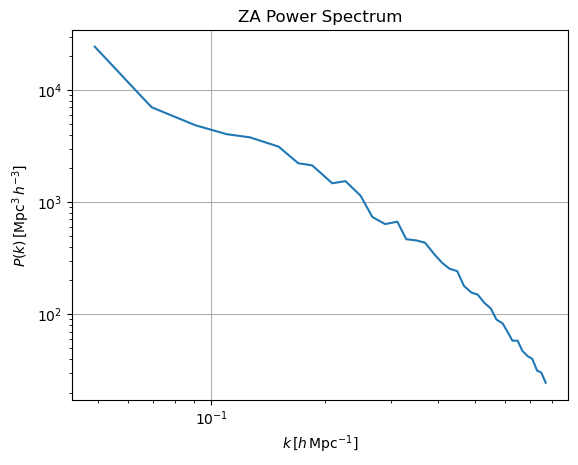

In [8]:
za_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+za_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
za_mesh = za_part.to_mesh(Nmesh=32,BoxSize=128)
za_fft = FFTPower(za_mesh, mode='1d', dk=0.02)

za_power_values = za_fft.power['power'].real 
power_values_list.append(za_power_values)

plt.loglog(k_values, za_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('ZA Power Spectrum')
plt.grid(True)
plt.show()

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


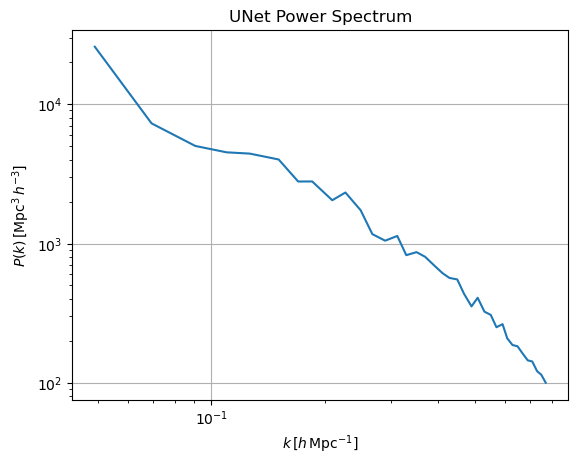

In [9]:
import torch
from nbodykit.source.catalog import ArrayCatalog

fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_0.0099', dataset='1/', header='Header')
fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)

from model1021 import Lpt2NbodyNetLightning
model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()
unet_displacement = model(za_tensor)

final_pos = pos_initial + unet_displacement.squeeze(0).detach().numpy()
final_pos = final_pos.transpose(1, 2, 3, 0).reshape(32**3, 3)

data = np.empty(32**3, dtype=[('Position', ('f8', 3))])
data['Position'] = final_pos

unet_part = ArrayCatalog(data)
unet_mesh = unet_part.to_mesh(Nmesh=32,BoxSize=128)

unet_fft = FFTPower(unet_mesh, mode='1d', dk=0.02)
unet_power_values = unet_fft.power['power'].real 
power_values_list.append(unet_power_values)

plt.loglog(k_values, unet_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('UNet Power Spectrum')
plt.grid(True)
plt.show()

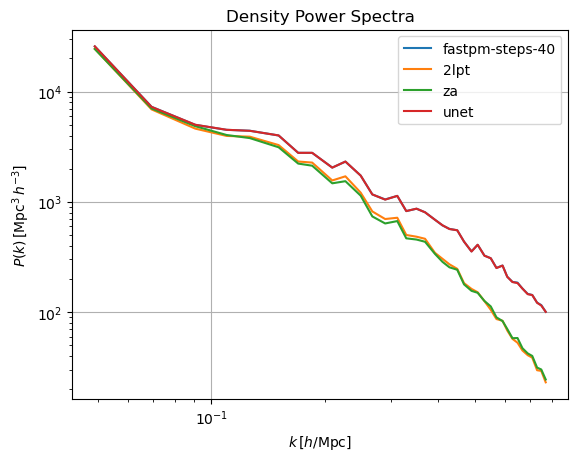

/tmp/ipykernel_3683834/4245589881.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k_values, np.sqrt(power_values / power_values_list[0]), label=labels[i])  # Plot transfer function


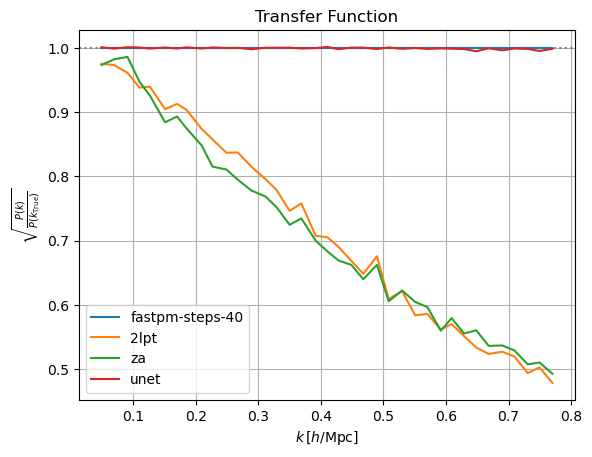

In [10]:
plt.figure()
for i, power_values in enumerate(power_values_list):
    plt.loglog(k_values, power_values, label=labels[i])  # Plot each power spectrum

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.legend()
plt.grid(True)
plt.title('Density Power Spectra')
plt.show()

# Second plot: Transfer function comparison
plt.figure()
for i, power_values in enumerate(power_values_list):
    if i == 0:
        plt.axhline(y=1, color='gray', linestyle=':', linewidth=1.5)  # Dotted line at y=1
    plt.plot(k_values, np.sqrt(power_values / power_values_list[0]), label=labels[i])  # Plot transfer function

# Move formatting functions outside the loop
#plt.ylim(0.6, 1.4)
#plt.xlim(0.0, 0.3)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sqrt{\frac{P(k)}{P(k_{\mathrm{True}})}}$')
plt.legend()
plt.grid(True)
plt.title('Transfer Function')
plt.show()

In [11]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import argparse
from nbodykit.lab import *
from pmesh.pm import ParticleMesh
from matplotlib.gridspec import GridSpec

dk = 0.02

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

def getPow(data1,data2=None):
    pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
    q = pm.generate_uniform_particle_grid(shift=0.5)
    den1 = pm.paint(q+data1.reshape([-1,3]))
    if(data2 is not None):
        pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
        den2 = pm.paint(q+data2.reshape([-1,3]))
        temp = FFTPower(first=den1, second=den2,mode='1d',BoxSize=128,dk=dk)
        k,powspec = temp.power['k'],temp.power['power']
    else:
        temp = FFTPower(den1, mode='1d',BoxSize=128,dk=dk)
        k,powspec = temp.power['k'],temp.power['power']
    return [k,powspec.real]

def getPow_dis(data1,data2=None):
    pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
    q = pm.generate_uniform_particle_grid(shift=0.5)
    den1 = pm.paint(q)
    power = 0
    if(data2 is not None):
        pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
        q = pm.generate_uniform_particle_grid(shift=0.5)
        den2 = pm.paint(q)
        for ii in range(3):
            den1[:] = data1[:,:,:,ii]
            den2[:] = data2[:,:,:,ii]
            temp = FFTPower(first = den1, second = den2, mode='1d',BoxSize=128,dk=dk)
            k,power = temp.power['k'], power+temp.power['power']
    else:
        for ii in range(3):
            den1[:] = data1[:,:,:,ii]
            temp = FFTPower(den1, mode='1d',BoxSize=128,dk=dk)
            k,power = temp.power['k'], power+temp.power['power']
    return [k,power.real]

def getPow_ave(test,LPT,Nbody,d):
    powLPT,powNbody,powRecon,powReconxNbody,powLPTxNbody = 0,0,0,0,0
    if(d==1):
        k,P = getPow_dis(LPT)
        powLPT += P
        k,P = getPow_dis(Nbody)
        powNbody += P
        k,P = getPow_dis(test)
        powRecon += P
        k,P = getPow_dis(test,Nbody)
        powReconxNbody += P
        k,P = getPow_dis(LPT,Nbody)
        powLPTxNbody += P
    else:
        k,P = getPow(LPT)
        powLPT += P
        k,P = getPow(Nbody)
        powNbody += P
        k,P = getPow(test)
        powRecon += P
        k,P = getPow(test,Nbody)
        powReconxNbody += P
        k,P = getPow(LPT,Nbody)
        powLPTxNbody += P
    return k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody

def plot_pow(k,powNbody,powLPT,powRecon,LxN,RxN,title):
    fig = plt.figure(figsize=(6,8))

    ax1 = plt.subplot2grid((4,1),(0,0),rowspan=2)
    plt.plot(k, powLPT,label = '2LPT')
    plt.plot(k, powRecon,label = 'U-Net')
    plt.plot(k, powNbody,label ='fastPM')
    plt.ylabel('P(k)')
    plt.yscale('log')
    plt.legend(loc='lower left')
    plt.title(title)
    plt.setp(ax1.get_xticklabels(),visible=False)

    ax2 = plt.subplot2grid((4,1),(2,0), rowspan = 1,sharex=ax1)
    plt.axhline(y=1, color='k', linestyle='--')
    plt.plot(k, powLPT/powNbody,label = 'LPT')
    plt.plot(k, powRecon/powNbody,label = 'Predict')
    plt.ylabel(r'$T(k)$')
    plt.setp(ax2.get_xticklabels(),visible=False)

    ax3 = plt.subplot2grid((4,1),(3,0),sharex=ax1)
    plt.loglog(k, 1-(LxN/np.sqrt(powLPT*powNbody))**2,label = 'LPTxNbody')
    plt.loglog(k, 1-(RxN/np.sqrt(powRecon*powNbody))**2,label = 'ReconxNbody')
    plt.xticks(np.round([0.06+0.01*i for i in range(0,4,2)]+ [0.1+0.1*i for i in range(0,7,2)],2),
               np.round([0.06+0.01*i for i in range(0,4,2)]+ [0.1+0.1*i for i in range(0,7,2)],2))
    plt.xticks(rotation=45)
    plt.ylabel(r'1-$r^2$')
    plt.show()

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/tmp/ipykernel_3683834/857822196.py:91: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, powLPT/powNbody,label = 'LPT')
/tmp/ipykernel_3683834/857822196.py:92: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, powRecon/powNbody,label = 'Predict')
/tmp/ipykernel_3683834/857822196.py:97: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(k, 1-(LxN/np.sqrt(powLPT*powNbody))**2,label = 'LPTxNbody')
/tmp/ipykernel_3683834/857822196.py:98: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(k, 1-(RxN/np.sqrt(powRecon*powNbody))**2,label = 'ReconxNbody')


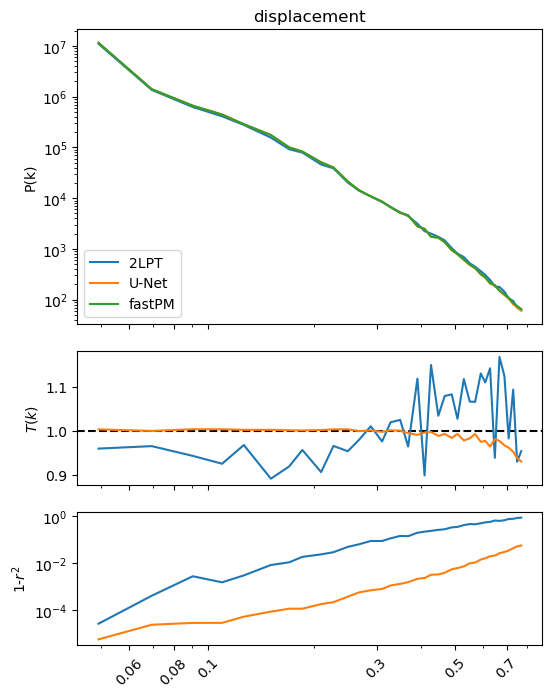

In [12]:
%matplotlib inline
import torch

fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_0.0099', dataset='1/', header='Header')
fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
twolpt_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,3:6]
fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]
za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)

from model1021 import Lpt2NbodyNetLightning
model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()
unet_displacement = model(za_tensor)

unet_displacement = unet_displacement.squeeze(0).permute(1, 2, 3, 0).detach().numpy()

k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=twolpt_displacement,Nbody=fastpm_displacement,d=1)
plot_pow(k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody,'displacement')

/tmp/ipykernel_3683834/857822196.py:91: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, powLPT/powNbody,label = 'LPT')
/tmp/ipykernel_3683834/857822196.py:92: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, powRecon/powNbody,label = 'Predict')
/tmp/ipykernel_3683834/857822196.py:97: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(k, 1-(LxN/np.sqrt(powLPT*powNbody))**2,label = 'LPTxNbody')
/tmp/ipykernel_3683834/857822196.py:98: RuntimeWarning: invalid value encountered in true_divide
  plt.loglog(k, 1-(RxN/np.sqrt(powRecon*powNbody))**2,label = 'ReconxNbody')


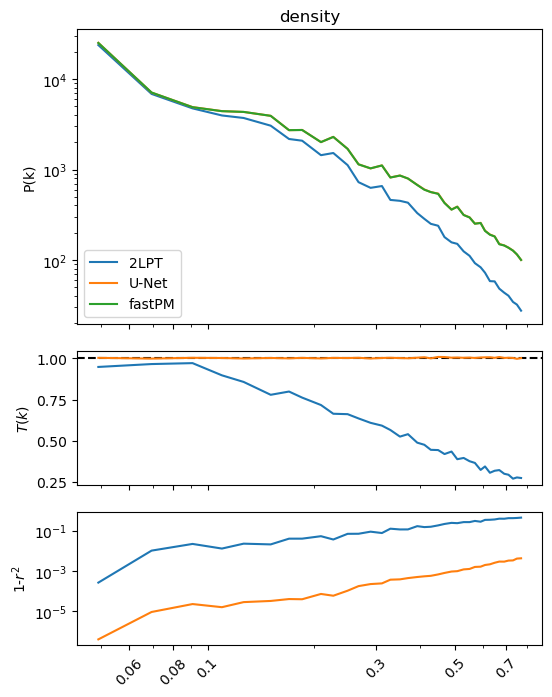

In [13]:
k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=za_displacement,Nbody=fastpm_displacement,d=0)
plot_pow(k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody,'density')

In [14]:
import torch

fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_0.0099', dataset='1/', header='Header')
fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
twolpt_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,3:6]
fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]
za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)

from model1021 import Lpt2NbodyNetLightning
model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()
unet_displacement = model(za_tensor)

unet_displacement = unet_displacement.squeeze(0).permute(1, 2, 3, 0).detach().numpy()

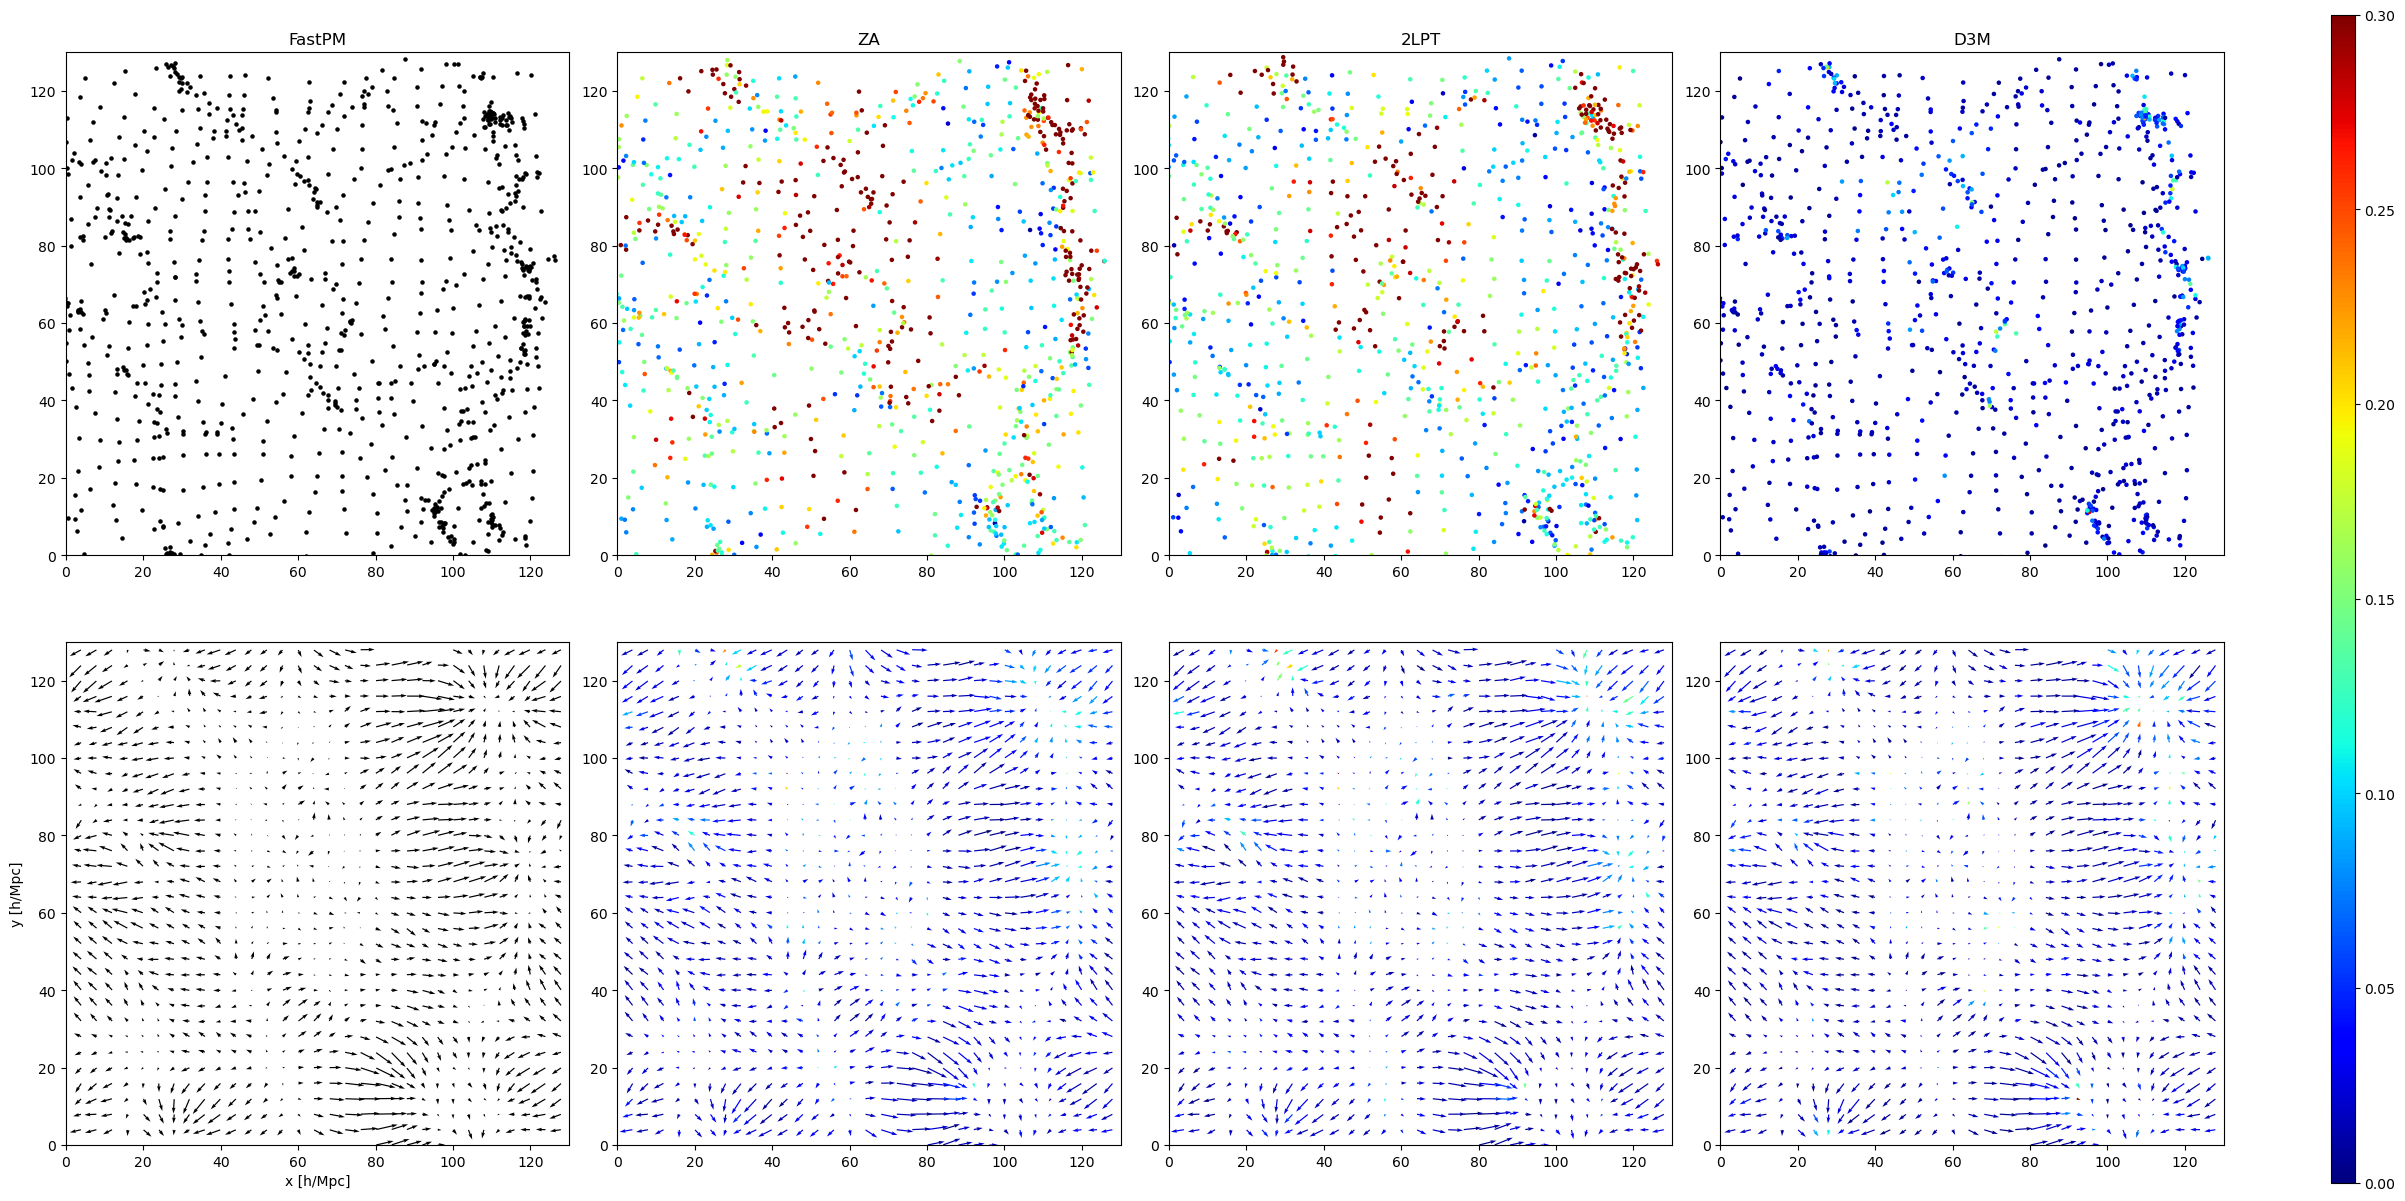

In [15]:
# Slice in z direction
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Select a slice to visualize (e.g., at z = grid_size // 2)
slice_index = 16

# Random initial positions
initial_positions = pos_initial.transpose(1, 2, 3, 0)

displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement
# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    error = (other-fastpm)
    error = np.linalg.norm(error, axis=-1) / np.linalg.norm(fastpm, axis=-1)
    return error

# Calculate relative errors for the final positions
rel_error_za = relative_error(displacement_fastpm[:, :, slice_index], displacement_za[:, :, slice_index])

rel_error_lpt = relative_error(displacement_fastpm[:, :, slice_index], displacement_lpt[:, :, slice_index])

rel_error_dm = relative_error(displacement_fastpm[:, :, slice_index], displacement_dm[:, :, slice_index])

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(final_positions_fastpm[:, :, slice_index, 0], final_positions_fastpm[:, :, slice_index, 1], 
                   c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, :, slice_index, 0], final_positions_za[:, :, slice_index, 1], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, :, slice_index, 0], final_positions_lpt[:, :, slice_index, 1], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, :, slice_index, 0], final_positions_dm[:, :, slice_index, 1], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Calculate relative error for the displacement vectors
rel_error_vectors_za = relative_error(displacement_fastpm[:, :, slice_index], displacement_za[:, :, slice_index])

rel_error_vectors_lpt = relative_error(displacement_fastpm[:, :, slice_index], displacement_lpt[:, :, slice_index])

rel_error_vectors_dm = relative_error(displacement_fastpm[:, :, slice_index], displacement_dm[:, :, slice_index])

# Vector field of the displacement field
Y, X = initial_positions[:, :, slice_index, 1], initial_positions[:, :, slice_index, 0]  # Use initial positions
U = displacement_fastpm[:, :, slice_index, 0]
V = displacement_fastpm[:, :, slice_index, 1]

# Create the quiver plot with colored vectors
quiver = axs[1, 0].quiver(X, Y, U, V, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Vector field for another displacement method (e.g., ZA)
U_za = displacement_za[:, :, slice_index, 0]
V_za = displacement_za[:, :, slice_index, 1]

# Create the quiver plot for ZA with colored vectors
quiver_za = axs[1, 1].quiver(X, Y, U_za, V_za, rel_error_vectors_za, cmap=plt.cm.jet)

U_lpt = displacement_lpt[:, :, slice_index, 0]
V_lpt = displacement_lpt[:, :, slice_index, 1]

# Create the quiver plot for ZA with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Y, U_lpt, V_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

U_dm = displacement_dm[:, :, slice_index, 0]
V_dm = displacement_dm[:, :, slice_index, 1]
# Create the quiver plot for ZA with colored vectors
quiver_dm = axs[1, 3].quiver(X, Y, U_dm, V_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 130)
    ax.set_ylim(0, 130)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()

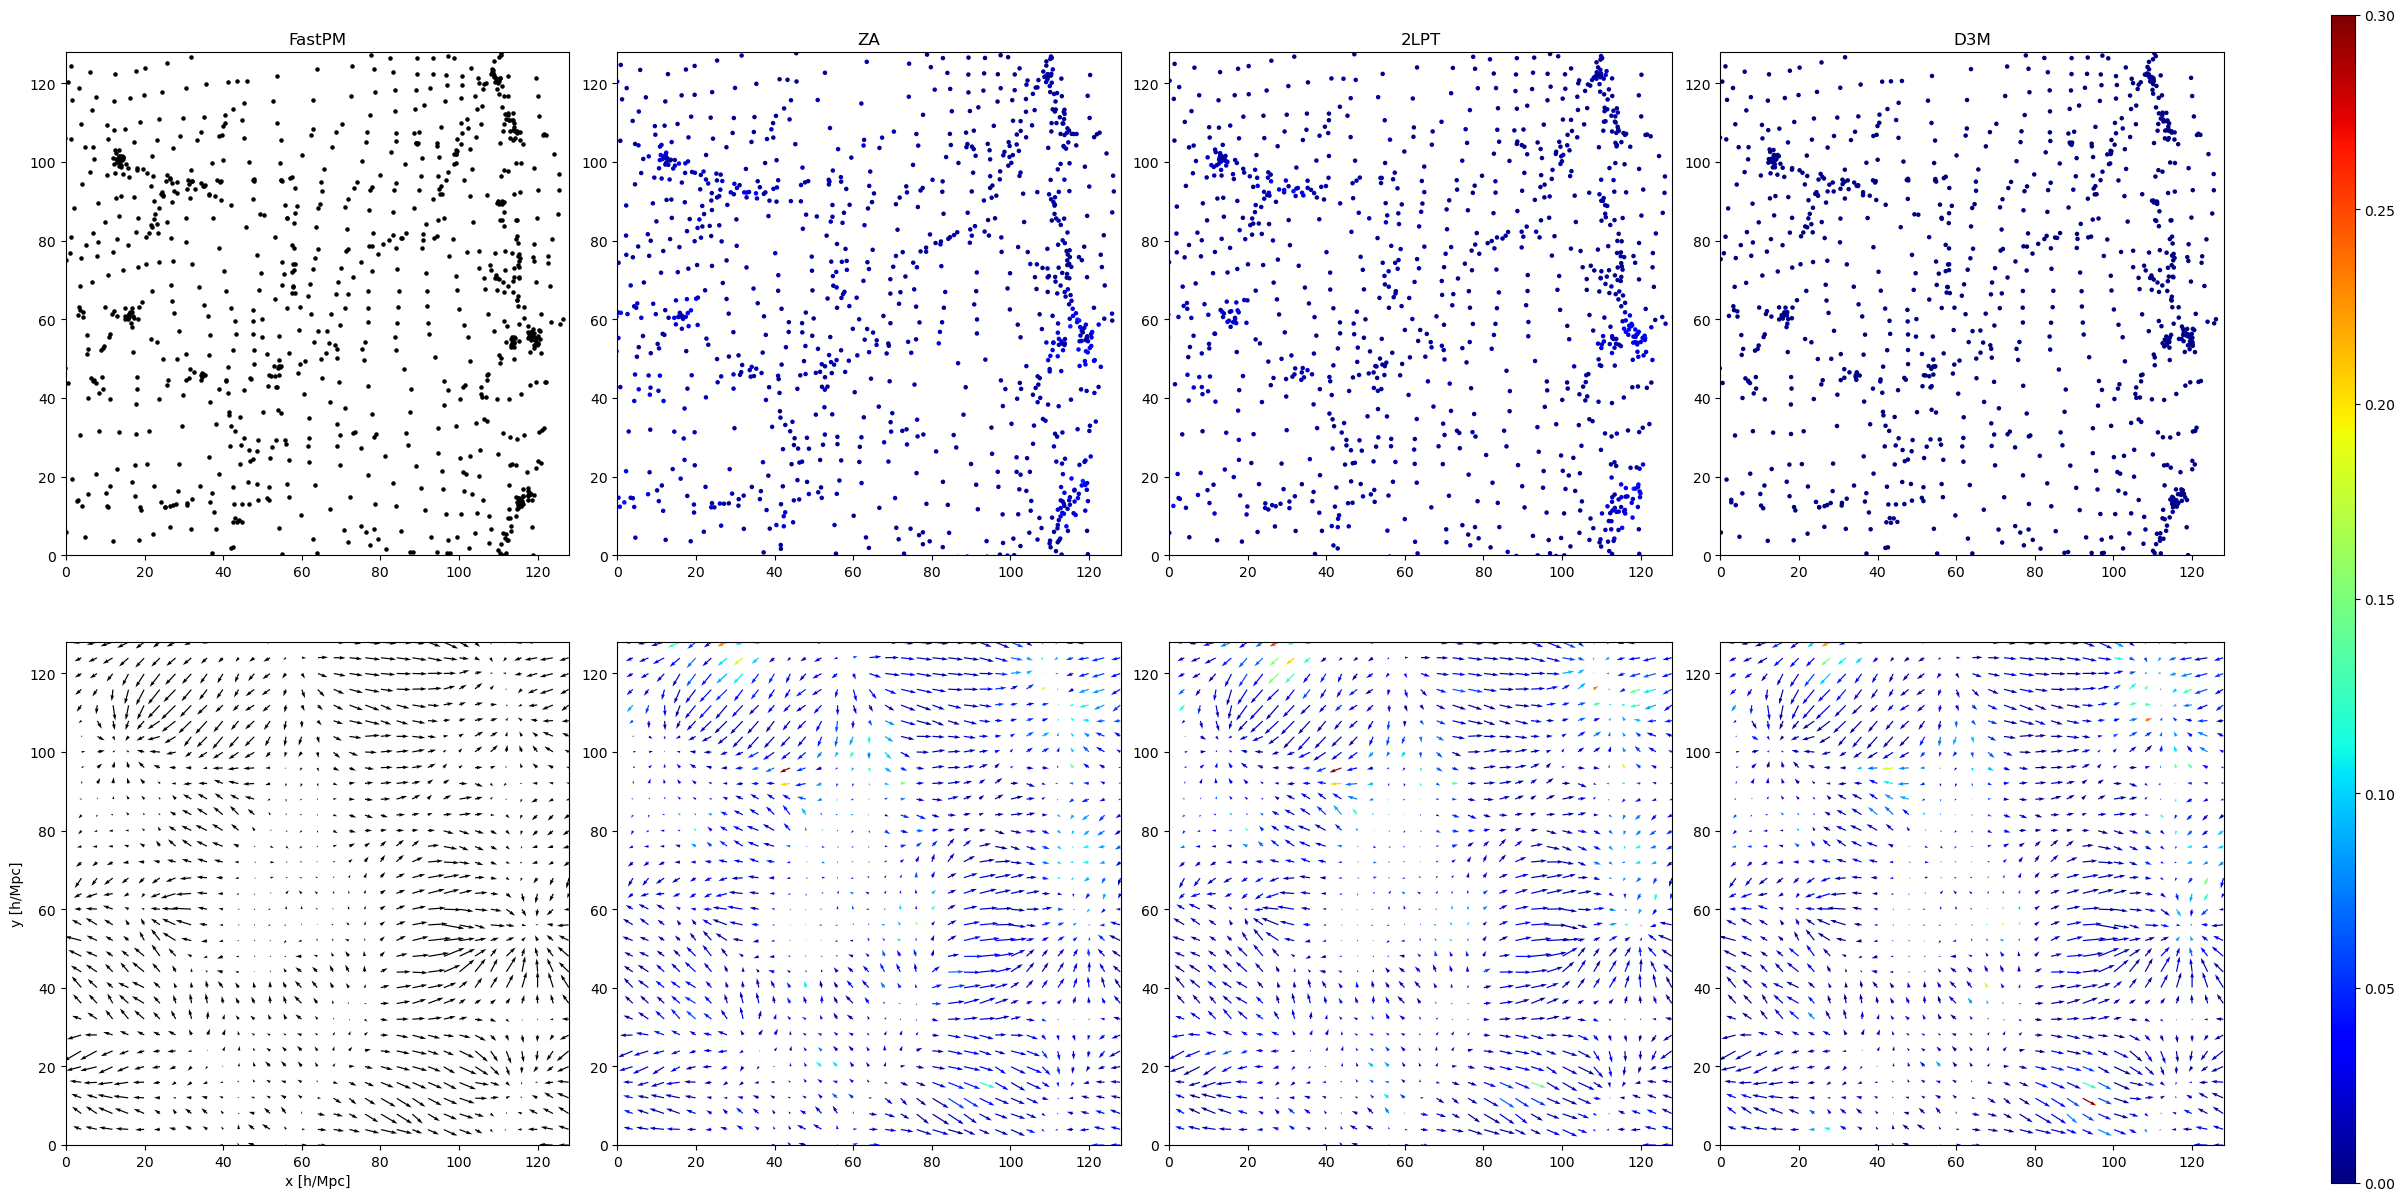

In [16]:
# Slice in y-direction
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Select a slice to visualize (e.g., at z = grid_size // 2)
slice_index = 20

# Random initial positions
initial_positions = pos_initial.transpose(1, 2, 3, 0)

displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement
# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    diff = np.linalg.norm(fastpm - other, axis=-1)  # Euclidean distance
    norm_fastpm = np.linalg.norm(fastpm, axis=-1)   # Norm of FastPM positions
    return diff / norm_fastpm

# Calculate relative errors for the final positions
rel_error_za = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_za[:, slice_index, :])

rel_error_lpt = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_lpt[:, slice_index, :])

rel_error_dm = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_dm[:, slice_index, :])

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(final_positions_fastpm[:, slice_index, :, 0], final_positions_fastpm[:, slice_index, :, 2], 
                   c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, slice_index, :, 0], final_positions_za[:, slice_index, :, 2], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, slice_index, :, 0], final_positions_lpt[:, slice_index, :, 2], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, slice_index, :, 0], final_positions_dm[:, slice_index, :, 2], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Calculate relative error for the displacement vectors
norm_rel_error_vectors_za = (rel_error_vectors_za.flatten() - np.min(rel_error_vectors_za.flatten())) / (np.max(rel_error_vectors_za.flatten()) - np.min(rel_error_vectors_za.flatten()))

norm_rel_error_vectors_lpt = (rel_error_vectors_lpt.flatten() - np.min(rel_error_vectors_lpt.flatten())) / (np.max(rel_error_vectors_lpt.flatten()) - np.min(rel_error_vectors_lpt.flatten()))

norm_rel_error_vectors_dm = (rel_error_vectors_dm.flatten() - np.min(rel_error_vectors_dm.flatten())) / (np.max(rel_error_vectors_dm.flatten()) - np.min(rel_error_vectors_dm.flatten()))

# Vector field of the displacement field
Z, X = initial_positions[:, slice_index, :, 2], initial_positions[:, slice_index, :, 0]  # Use initial positions
U = displacement_fastpm[:, slice_index, :, 0]
W = displacement_fastpm[:, slice_index, :, 2]

# Create the quiver plot with colored vectors
quiver = axs[1, 0].quiver(X, Z, U, W, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Vector field for another displacement method (e.g., ZA)
U_za = displacement_za[:, slice_index, :, 0]
W_za = displacement_za[:, slice_index, :, 2]

# Create the quiver plot for ZA with colored vectors
quiver_za = axs[1, 1].quiver(X, Z, U_za, W_za, rel_error_vectors_za, cmap=plt.cm.jet)

U_lpt = displacement_lpt[:, slice_index, :, 0]
W_lpt = displacement_lpt[:, slice_index, :, 2]

# Create the quiver plot for 2lpt with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Z, U_lpt, W_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

U_dm = displacement_dm[:, slice_index, :, 0]
W_dm = displacement_dm[:, slice_index, :, 2]
# Create the quiver plot for d3m with colored vectors
quiver_dm = axs[1, 3].quiver(X, Z, U_dm, W_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 128)
    ax.set_ylim(0, 128)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()

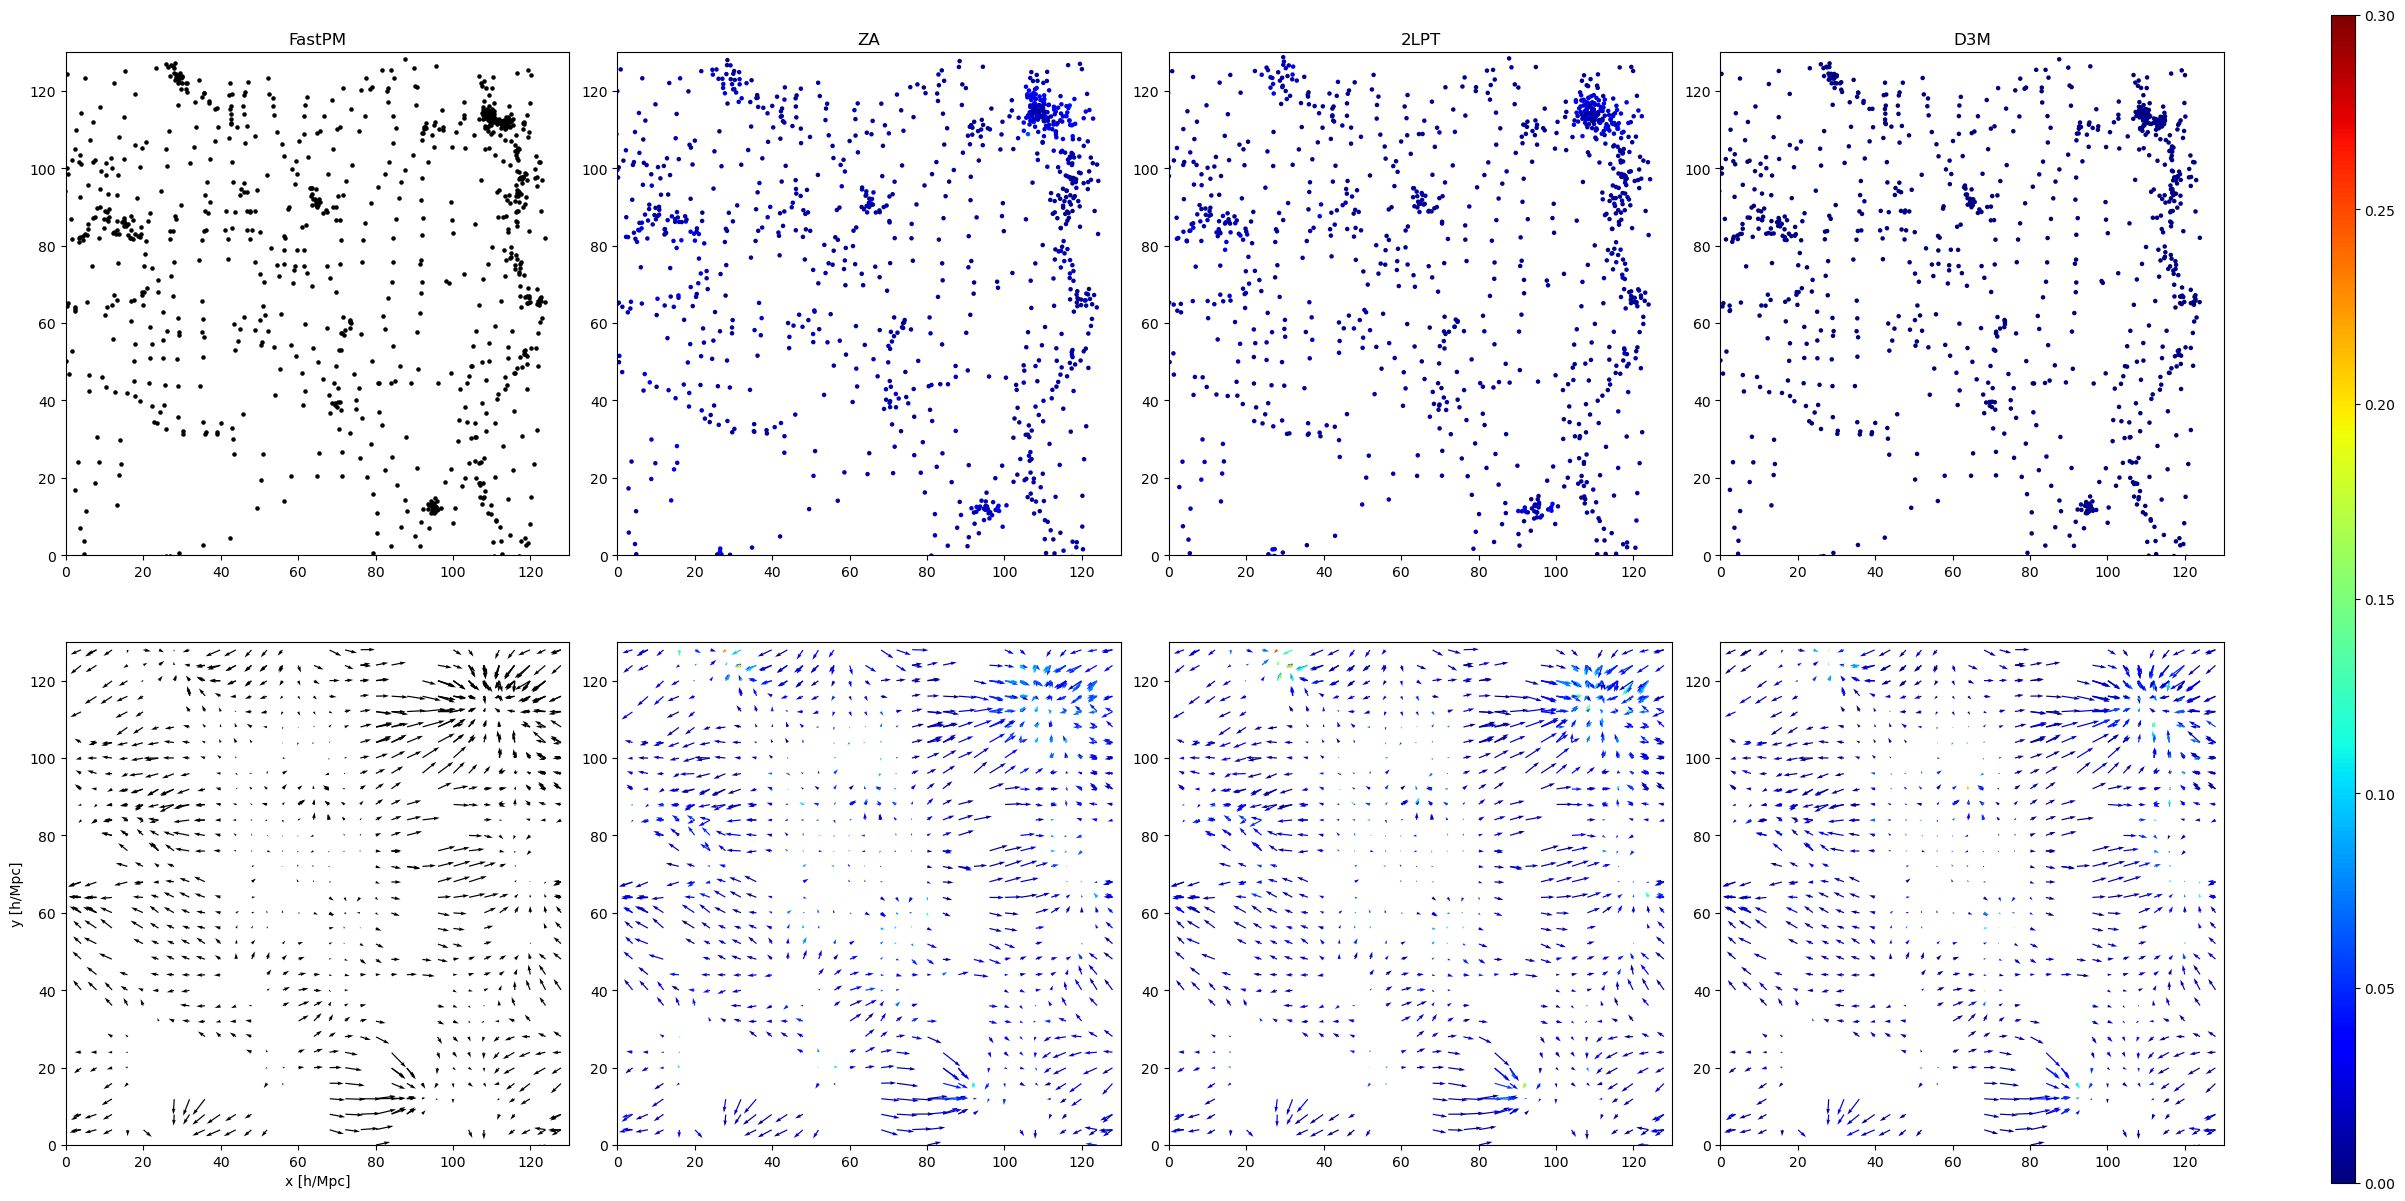

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Choose the actual z-value for the slice
z_slice_value = 64  # Example: slice at z = 50 Mpc/h
slice_width = 2     # Tolerance for z slice (e.g., ±5 Mpc/h)

# Random initial positions (shape: (32, 32, 32, 3))
initial_positions = pos_initial.transpose(1, 2, 3, 0)

# Displacement fields (shape: (32, 32, 32, 3))
displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement

# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    diff = np.linalg.norm(fastpm - other, axis=-1)  # Euclidean distance
    norm_fastpm = np.linalg.norm(fastpm, axis=-1)   # Norm of FastPM positions
    return diff / norm_fastpm

# Filter particles close to the desired z-value
z_final = final_positions_fastpm[:, :, :, 2]  # Extract the z-coordinates of final positions
slice_mask = (z_final > z_slice_value - slice_width) & (z_final < z_slice_value + slice_width)

# Apply the mask to get the particles in the slice
x_slice = final_positions_fastpm[:, :, :, 0][slice_mask]
y_slice = final_positions_fastpm[:, :, :, 1][slice_mask]

# Calculate relative errors for the final positions (for particles in the slice)
rel_error_za = relative_error(final_positions_fastpm[slice_mask], final_positions_za[slice_mask])
rel_error_lpt = relative_error(final_positions_fastpm[slice_mask], final_positions_lpt[slice_mask])
rel_error_dm = relative_error(final_positions_fastpm[slice_mask], final_positions_dm[slice_mask])

# Normalize relative errors for color mapping
norm_rel_error_za = (rel_error_za - np.min(rel_error_za)) / (np.max(rel_error_za) - np.min(rel_error_za))
norm_rel_error_lpt = (rel_error_lpt - np.min(rel_error_lpt)) / (np.max(rel_error_lpt) - np.min(rel_error_lpt))
norm_rel_error_dm = (rel_error_dm - np.min(rel_error_dm)) / (np.max(rel_error_dm) - np.min(rel_error_dm))

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(x_slice, y_slice, c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, :, :, 0][slice_mask], final_positions_za[:, :, :, 1][slice_mask], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, :, :, 0][slice_mask], final_positions_lpt[:, :, :, 1][slice_mask], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, :, :, 0][slice_mask], final_positions_dm[:, :, :, 1][slice_mask], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Vector field of the displacement field
Y, X = initial_positions[:, :, :, 1][slice_mask], initial_positions[:, :, :, 0][slice_mask]  # Use initial positions
U = displacement_fastpm[:, :, :, 0][slice_mask]
V = displacement_fastpm[:, :, :, 1][slice_mask]

quiver_za = axs[1, 0].quiver(X, Y, U, V, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Calculate relative error for the displacement vectors (for particles in the slice)
rel_error_vectors_za = relative_error(displacement_fastpm[slice_mask], displacement_za[slice_mask])
rel_error_vectors_lpt = relative_error(displacement_fastpm[slice_mask], displacement_lpt[slice_mask])
rel_error_vectors_dm = relative_error(displacement_fastpm[slice_mask], displacement_dm[slice_mask])

U_za = displacement_za[:, :, :, 0][slice_mask]
V_za = displacement_za[:, :, :, 1][slice_mask]
# Create the quiver plot with colored vectors for FastPM vs ZA
quiver_za = axs[1, 1].quiver(X, Y, U_za, V_za, rel_error_vectors_za, cmap=plt.cm.jet)

# Vector field for 2LPT
U_lpt = displacement_lpt[:, :, :, 0][slice_mask]
V_lpt = displacement_lpt[:, :, :, 1][slice_mask]

# Create the quiver plot for 2LPT with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Y, U_lpt, V_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

# Vector field for D3M
U_dm = displacement_dm[:, :, :, 0][slice_mask]
V_dm = displacement_dm[:, :, :, 1][slice_mask]

# Create the quiver plot for D3M with colored vectors
quiver_dm = axs[1, 3].quiver(X, Y, U_dm, V_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 130)
    ax.set_ylim(0, 130)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()


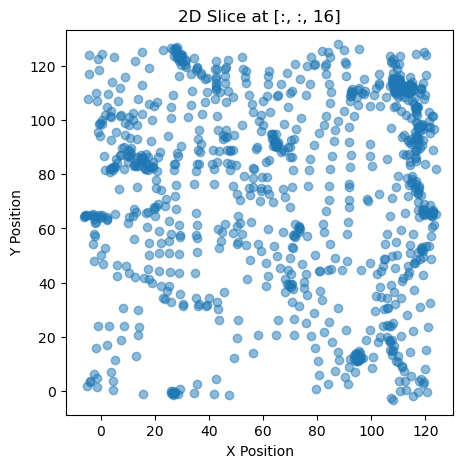

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the x, y, z components of positions

x = initial_positions[:,:,16, 0]
y = initial_positions[:,:,16, 0]

# Plotting the 2D slice
plt.figure(figsize=(5, 5))
plt.scatter(x_slice, y_slice, alpha=0.5)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'2D Slice at [:, :, 16]')
plt.axis('equal')  # Optional: to maintain aspect ratio
plt.show()

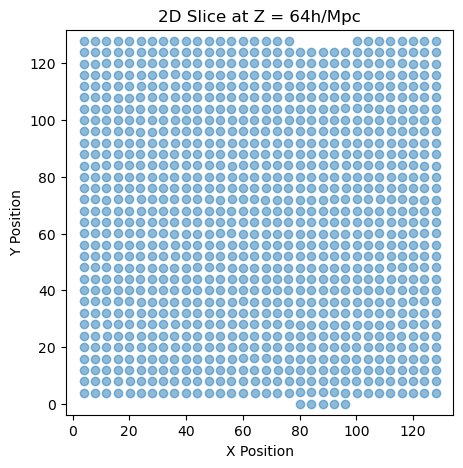

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the x, y, z components of positions
rinitial_positions = initial_positions.reshape(-1,3)
x = rinitial_positions[:, 0]
y = rinitial_positions[:, 1]
z = rinitial_positions[:, 2]

# Choose a z value to slice through
z_slice = 64  # Adjust this value based on your data range

# Create a mask for the points close to the chosen z value
tolerance = 2  # Adjust tolerance as needed
mask = (z >= z_slice - tolerance) & (z <= z_slice + tolerance)

# Filter x and y based on the mask
x_slice = x[mask]
y_slice = y[mask]

# Plotting the 2D slice
plt.figure(figsize=(5, 5))
plt.scatter(x_slice, y_slice, alpha=0.5)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'2D Slice at Z = {z_slice}h/Mpc')
plt.axis('equal')  # Optional: to maintain aspect ratio
plt.show()